C:\Users\andrgome\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\andrgome\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\andrgome\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

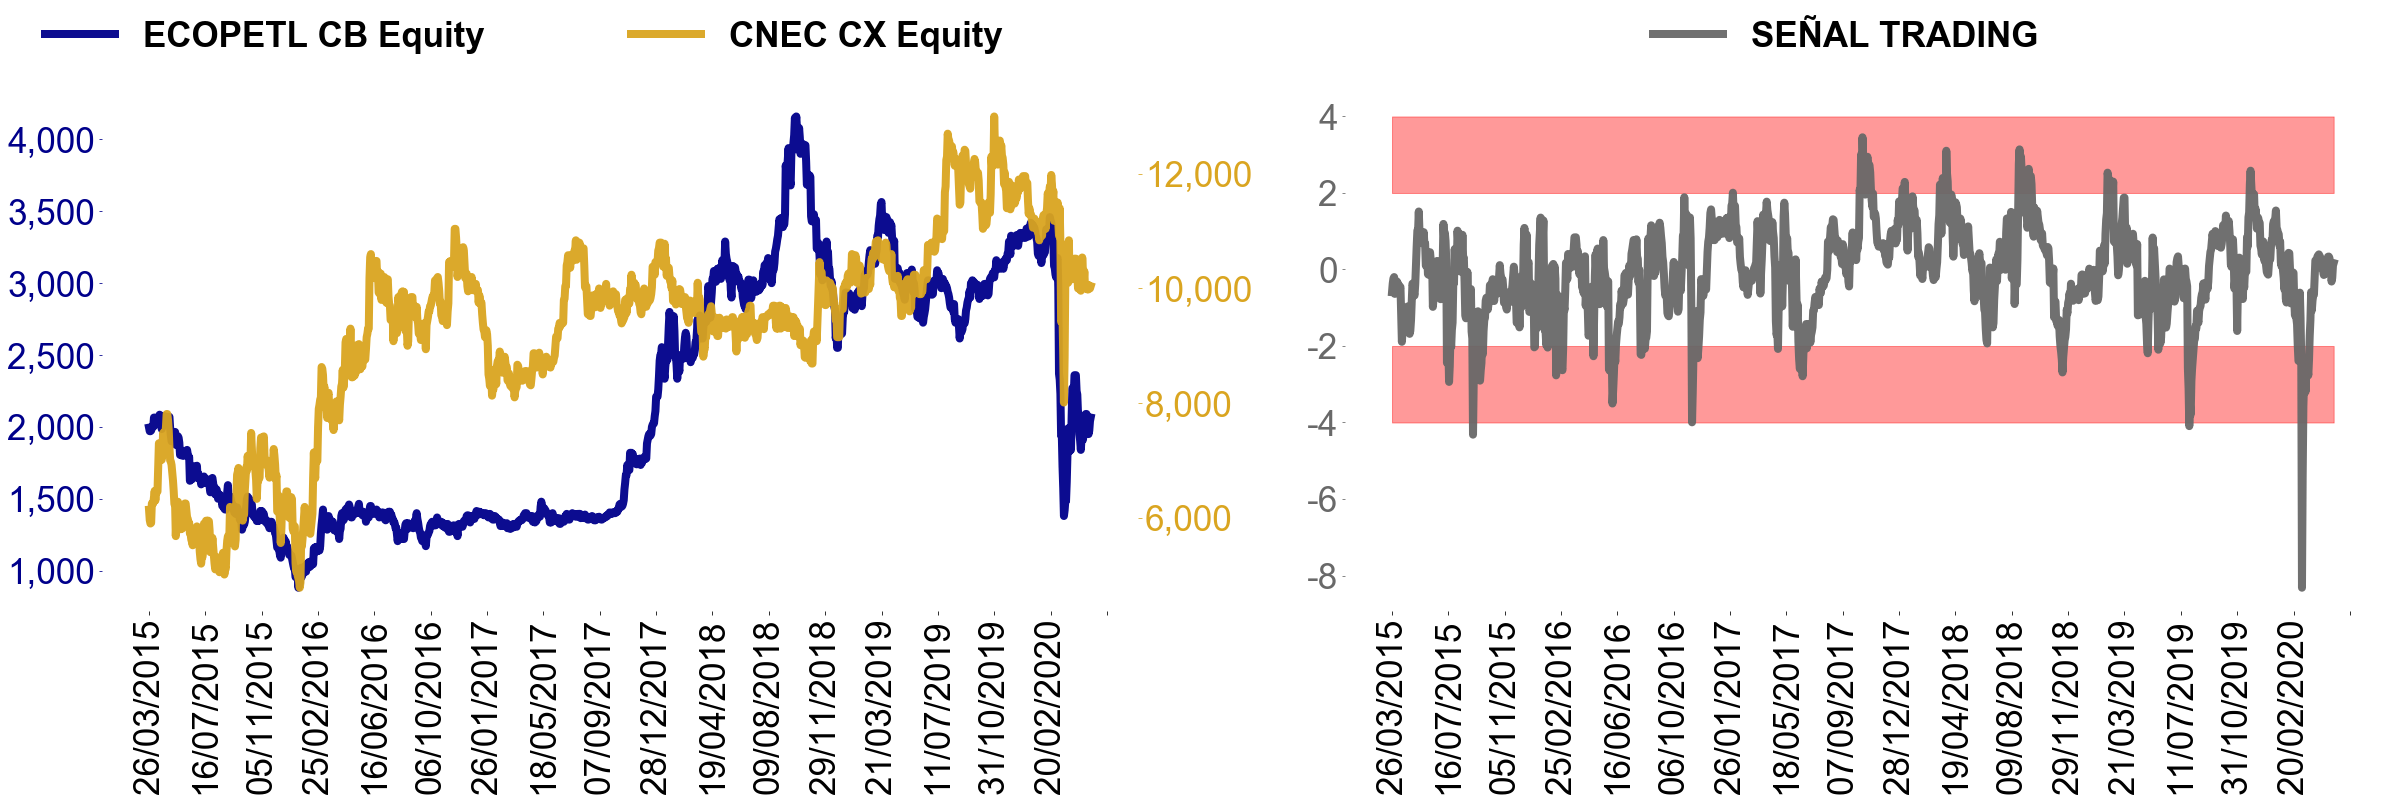

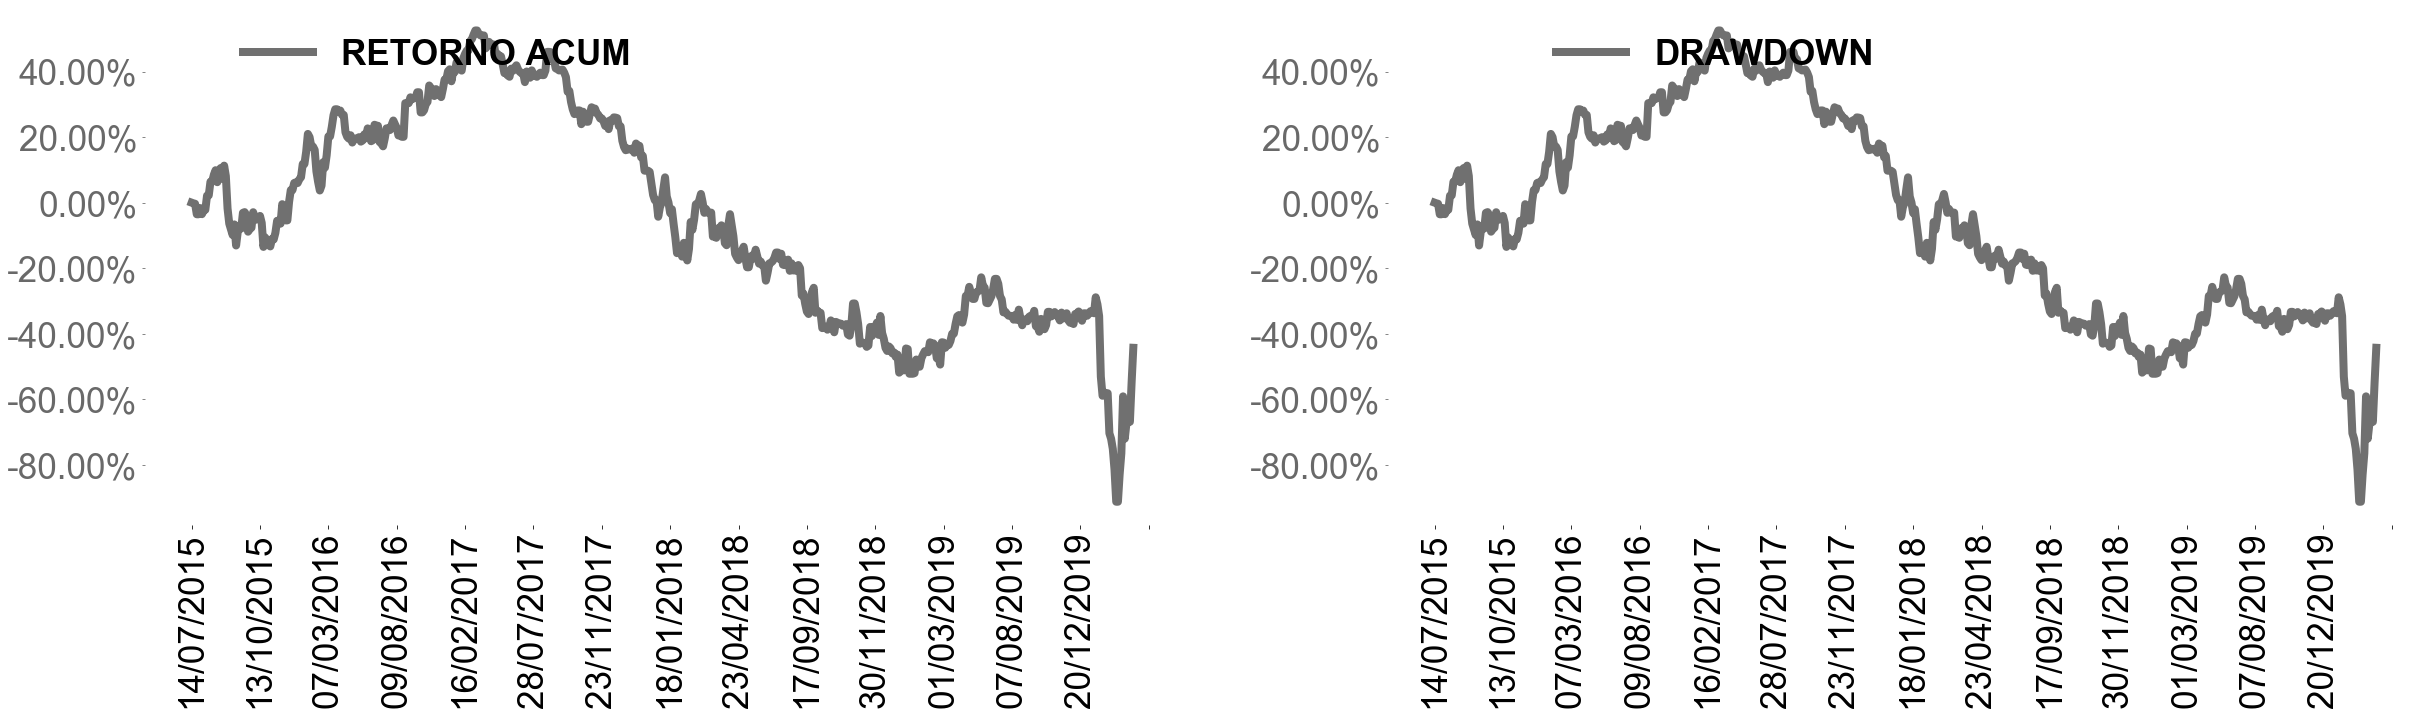

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager

df = pd.read_csv('D:/andrgome/Documents/BDPython/BDPRECIOS_PARES.csv',encoding='latin-1')

#CUANDO LA SEÑAL ES BUY SE COMPRA EL ACTIVO1 Y SE VENDE EL ACTIVO2 - CUANDO LA SEÑAL ES SELL VICEVERSA
ACTIVO1 = 'ECOPETL CB Equity'
ACTIVO2 = 'CNEC CX Equity'
n = 30

#CREACIÓN DE LA SEÑAL
df_par = pd.DataFrame()
df_par['Fecha'] = df['Fecha']
df_par['ACTIVO1'] = df[ACTIVO1]
df_par['ACTIVO2'] = df[ACTIVO2]
df_par['Log_ret'] = np.log(df[ACTIVO1])-np.log(df[ACTIVO2])
df_par['Prom_mov'] = df_par.iloc[:,3].rolling(window=n).mean()
df_par['Dif'] = df_par['Log_ret'] - df_par['Prom_mov']
df_par['Dif_cuad'] = (df_par['Log_ret'] - df_par['Prom_mov'])**2
df_par['Prom_mov_2raiz'] = (df_par.iloc[:,6].rolling(window=n).mean())**0.5
df_par['Cociente'] = df_par['Dif'][1:].values/df_par['Prom_mov_2raiz'][:-1]
df_par['Cociente']=df_par['Cociente'].shift(periods=1) 
df_par['Posición'] = ""
df_par['Trade'] = ""
df_par = df_par.iloc[2*n:]


#BACKTESTING
#Inicialización de parámetros
UP = 2
DOWN = -2
PROFIT = 0
df_par['Posición'].iloc[0]  = 'FLAT' 
Posición = 'FLAT'
Trade = 'NTG'

#Función para calcular la posición actual y el trade que debe hacerse en cada momento
def calcular_posicion(Cociente):  
        
    global Posición
    global Trade     
    
    if Posición == 'FLAT':        
        if Cociente > UP:
            Trade = 'SELL'
            Posición = 'SHORT'
        elif Cociente < DOWN:
            Trade = 'BUY'
            Posición = 'LONG'
        else: 
            Trade = 'NTG'
            Posición = 'FLAT'
    
    elif Posición == 'SHORT':
        if Cociente < PROFIT:
            Trade = 'BUY'
            Posición = 'FLAT'
        else: 
            Trade = 'NTG'
            Posición = 'SHORT'
    
    elif Posición == 'LONG':    
        if Cociente > PROFIT:
            Trade = 'SELL'
            Posición = 'FLAT'
        else: 
            Trade = 'NTG'
            Posición = 'LONG'       
        
    return Posición, Trade

#Asignando los resultados de la función calcular_posicion al dataframe
resultado = df_par.apply(lambda row: calcular_posicion(Cociente=row['Cociente']),axis=1)
df_par['Posición'] = [x[0] for x in resultado]
df_par['Trade'] = [x[1] for x in resultado]

#Calculando los retornos de los trades en los que se entraron
df_trades = df_par[df_par['Posición'].isin(['LONG'])|df_par['Posición'].isin(['SHORT'])|df_par['Trade'].isin(['BUY'])|df_par['Trade'].isin(['SELL'])]  #dejamos solo las filas cuando hay posición
df_trades['retorno'] = df_trades['Log_ret'][:-1].values-df_trades['Log_ret'][1:]
conditions = [ (df_trades['Posición'] == 'SHORT') , (df_trades['Posición'] == 'LONG'), (df_trades['Posición'] == 'FLAT')&(df_trades['Trade'] == 'BUY'),(df_trades['Posición'] == 'FLAT')&(df_trades['Trade'] == 'SELL')]     
choices = [1.0,-1.0,1.0,-1.0]
df_trades['retorno_signo'] = np.select(conditions, choices, default='null')
df_trades['retorno_signo'] = df_trades['retorno_signo'].astype(float)
df_trades.loc[(df_trades.Posición == 'SHORT')&(df_trades.Trade == 'SELL')|(df_trades.Posición == 'LONG')&(df_trades.Trade == 'BUY'),'retorno']=0
df_trades['retorno_disc'] = np.exp(df_trades['retorno']*df_trades['retorno_signo'])-1
df_trades['retorno_acum'] = df_trades['retorno_disc'].cumsum()



#GRAFICAR
tick_spacing1 = 80
tick_spacing2 = 80
tick_spacing3 = 40
Tamaño = 35
font = font_manager.FontProperties(family='arial',weight='bold', style='normal', size=Tamaño)

fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 2, 1)  # Esto significa un gráfico de 1x2 y es el subplot 1
ax1.plot(df_par['Fecha'],df_par['ACTIVO1'],marker='None', linestyle='solid',linewidth=8,color='darkblue',alpha = 0.95,label=ACTIVO1,markersize=5)
ax1.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(0.4, 1.2),ncol=2,markerscale=3)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing1))
plt.xticks(rotation=90)
plt.yticks(fontname = "Arial",fontsize=Tamaño)
plt.xticks(fontname = "Arial",fontsize=Tamaño)
ax1.axis([None, None, None, None])
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:0,.0f}'.format(x) for x in vals])
ax1.tick_params(axis='y', color = 'darkblue', labelcolor='darkblue')
plt.box(on=None)

ax11 = ax1.twinx()
ax11.plot(df_par['Fecha'],df_par['ACTIVO2'],marker='None', linestyle='solid',linewidth=8,color='goldenrod',alpha = 0.95,label=ACTIVO2,markersize=5)
ax11.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(0.9, 1.2),ncol=2,markerscale=3)
ax11.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing2))
plt.yticks(fontname = "Arial",fontsize=Tamaño)
plt.xticks(fontname = "Arial",fontsize=Tamaño)
ax11.axis([None, None, None, None])
vals = ax11.get_yticks()
ax11.set_yticklabels(['{:0,.0f}'.format(x) for x in vals])
ax11.tick_params(axis='y', color = 'goldenrod', labelcolor='goldenrod')
plt.box(on=None)

ax2 = fig1.add_subplot(1, 2, 2)
ax2.plot(df_par['Fecha'],df_par['Cociente'],marker='None', linestyle='solid',linewidth=8,color='dimgrey',alpha = 0.95,label='SEÑAL TRADING',markersize=5)
ax2.fill_between(df_par['Fecha'],2,4,color='red', alpha= 0.4)
ax2.fill_between(df_par['Fecha'],-2,-4,color='red', alpha= 0.4)
ax2.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(0.7, 1.2),ncol=2,markerscale=3)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing1))
plt.xticks(rotation=90)
plt.yticks(fontname = "Arial",fontsize=Tamaño)
plt.xticks(fontname = "Arial",fontsize=Tamaño)
ax2.axis([None, None, None, None])
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:0,.0f}'.format(x) for x in vals])
ax2.tick_params(axis='y', color = 'dimgrey', labelcolor='dimgrey')
plt.box(on=None)

plt.subplots_adjust(wspace = 0.2,bottom=0.1, right=5.4, top=1.9)

fig2 = plt.figure()
ax3 = fig2.add_subplot(1, 2, 1)
ax3.plot(df_trades['Fecha'],df_trades['retorno_acum'],marker='None', linestyle='solid',linewidth=8,color='dimgrey',alpha = 0.95,label='RETORNO ACUM',markersize=5)
ax3.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(0.5, 1.0),ncol=2,markerscale=3)
ax3.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing3))
plt.xticks(rotation=90)
plt.yticks(fontname = "Arial",fontsize=Tamaño)
plt.xticks(fontname = "Arial",fontsize=Tamaño)
ax3.axis([None, None, None, None])
vals = ax3.get_yticks()
ax3.set_yticklabels(['{:0,.2%}'.format(x) for x in vals])
ax3.tick_params(axis='y', color = 'dimgrey', labelcolor='dimgrey')
plt.box(on=None)

ax4 = fig2.add_subplot(1, 2, 2)
ax4.plot(df_trades['Fecha'],df_trades['retorno_acum'],marker='None', linestyle='solid',linewidth=8,color='dimgrey',alpha = 0.95,label='DRAWDOWN',markersize=5)
ax4.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(0.5, 1.0),ncol=2,markerscale=3)
ax4.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing3))
plt.xticks(rotation=90)
plt.yticks(fontname = "Arial",fontsize=Tamaño)
plt.xticks(fontname = "Arial",fontsize=Tamaño)
ax4.axis([None, None, None, None])
vals = ax4.get_yticks()
ax4.set_yticklabels(['{:0,.2%}'.format(x) for x in vals])
ax4.tick_params(axis='y', color = 'dimgrey', labelcolor='dimgrey')
plt.box(on=None)

plt.subplots_adjust(wspace = 0.2,bottom=0.1, right=5.4, top=1.9)

plt.show()

df_trades.to_csv('D:/andrgome/Documents/BDPython/TradingPares.csv', index = False)





In [34]:
df_trades.tail(30)

,Fecha,ACTIVO1,ACTIVO2,Log_ret,Prom_mov,Dif,Dif_cuad,Prom_mov_2raiz,Cociente,Posición,Trade,retorno,retorno_signo,retorno_disc,retorno_acum
1280,28/11/2019,32500,27700,0.159808,0.145565,0.014243,0.000203,0.031533,0.449724,SHORT,NTG,0.023009,1.0,0.023276,0.878018
1281,29/11/2019,32400,27140,0.177150,0.147595,0.029555,0.000874,0.031792,0.937280,SHORT,NTG,-0.017342,1.0,-0.017193,0.860826
1282,02/12/2019,32340,27480,0.162846,0.148890,0.013957,0.000195,0.031547,0.438993,SHORT,NTG,0.014303,1.0,0.014406,0.875232
1283,03/12/2019,32700,27680,0.166665,0.150715,0.015950,0.000254,0.031600,0.505580,SHORT,NTG,-0.003819,1.0,-0.003811,0.871420
1284,04/12/2019,33480,28040,0.177316,0.152935,0.024381,0.000594,0.031861,0.771555,SHORT,NTG,-0.010651,1.0,-0.010595,0.860826
1285,05/12/2019,33100,27920,0.170190,0.154984,0.015206,0.000231,0.031959,0.477261,SHORT,NTG,0.007126,1.0,0.007152,0.867977
1286,06/12/2019,32980,28000,0.163697,0.157103,0.006594,0.000043,0.031977,0.206338,SHORT,NTG,0.006493,1.0,0.006514,0.874492
1287,09/12/2019,32500,28040,0.147608,0.157997,-0.010389,0.000108,0.031891,-0.324876,FLAT,BUY,0.016089,1.0,0.016219,0.890711
1347,02/03/2020,29500,26000,0.126294,0.155406,-0.029112,0.000848,0.009795,-3.423817,LONG,BUY,0.000000,-1.0,0.000000,0.890711
1348,03/03/2020,29260,25700,0.129730,0.154331,-0.024601,0.000605,0.010548,-2.511468,LONG,NTG,-0.003437,-1.0,0.003443,0.894153
